# Mini-project I: Parameter estimation for a toy model of an EFT

The overall project goal is to reproduce various results in this paper: [*Bayesian parameter estimation for effective field theories*](https://arxiv.org/abs/1511.03618).  It's a long paper, so don't try to read all of it!  (At least not now.)  We'll guide you to the relevant parts.

The paper uses toy models for effective field theories, namely Taylor series of some specified functions, to present guidelines for parameter estimation. This will also be a check of whether you can follow (or give you practice on) Bayesian statistics discussions in the physics literature.

You'll find summaries in section II that touch on topics we have discussed and will discuss.  The function 

$$
g(x) = \left(\frac12 + \tan\left(\frac{\pi}{2}x\right)\right)^2
$$

represents the true, underlying theory.  It has a Taylor expansion

$$
g(x) = 0.25 + 1.57x + 2.47x^2 + 1.29 x^3 + \cdots
$$

Our model for an EFT for this "theory" is

$$
g_{\rm th}(x) \equiv \sum_{i=0}^k a_i x^i
$$

and your general task is to fit 1, 2, 3, ... of the constants $a_i$, and analyze the results.
**Your primary goal is to reproduce and interpret Table III on page 12 of the arXiv preprint.  A secondary goal is to reproduce and interpret Figure 1 of the same paper.**  You should use the emcee sampler and corner to make plots.


<div style="float:center;"><img src="miniproject_I_figure.png" width=700px></div>



### Learning goals:
* Apply and extend the Bayesian parameter estimation ideas and techniques from the course.
* Explore the impact of control features:  dependence on how much data is used and how precise it is; apply an *informative* prior.
* Learn about some diagnostics for Bayesian parameter estimation.
* Try out sampling on a controlled problem.

### Suggestions for how to proceed:
* Follow the lead of the notebooks [Gaussian noise](https://furnstahl.github.io/Physics-8820/notebooks/Parameter_estimation/parameter_estimation_Gaussian_noise.html) and [Fitting a straight line II [ipynb]](https://furnstahl.github.io/Physics-8820/notebooks/Why_Bayes_is_better/parameter_estimation_fitting_straight_line_II.html).
* Define a function for the exact result plus noise, noting from the arXiv paper what type of noise is added and where the points are located (i.e., what values of $x$). 
* Define functions for the two choices of prior and for the likelihood. Also a function for the posterior.
* Call emcee to sample the posteriors.
* Use corner to create plots.  You can read the answers for the tables from the corner plots (it is also possible to extract the numbers directly: see the example at the bottom of [this page](https://emcee.readthedocs.io/en/latest/tutorials/line/) from the emcee documentation).
* Don't try to do too much in your code at first (start with the lowest order in Table III). 
* Fill in the rest of Table III.  Characterize and explain the different results from the two priors (also: which one is equivalent to standard least-squares fitting?).  
* Generate figures for the lowest orders analogous to Figure 1 and then reproduce Figure 1.  Interpret the projected posteriors (e.g., what coefficients are very correlated and how does this relate to overfitting?) and identify where the "prior is returned". 


### Comments and suggestions
* To reproduce precisely (within fluctuations from the sampling) the numbers in Table III, you'll need to use the same data set used in the table.  This is available from the arXiv as [D1_c_5.dat](https://arxiv.org/src/1511.03618v3/anc/D1_c_5.dat).  These values are those plotted in the figure at the top of this notebook.
* The 5% error is a *relative* error, meaning it is 0.05 times the data at that point.  This means if you generate a Gaussian random number `err` distributed with standard deviation 0.05, the value of sigma for the log likelihood is `sigma[i] = data[i] * err` (use the data, not the theory at `i`).
* The `show_titles=True` option to corner will show central results and one-$\sigma$ error limits on the projected posterior plots.
* The `quantiles=[0.16, 0.5, 0.84]`option to corner adds the dashed vertical lines to the marginal posteriors on the diagonal. You can obviously change the quantiles if you want another credibility region.
* The Python command `np.percentile(samples, [16, 50, 84],axis=0)` might be useful to extract numerical values for the credibility region and the mean from a python array `samples`of shape (nsamples,ndimensions).
* The example on [Fitting a Model to Data](https://emcee.readthedocs.io/en/v2.2.1/user/line/) from the emcee documentation may be useful to supplement the examples in the other notebooks.
* Defining Python functions to do the sampling and plotting will make it much more efficient (and easier) to generate the numbers in the table or the particular plots for figure 1.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("talk")
from scipy import stats
import emcee
print('emcee sampling (version: )', emcee.__version__)
import corner
from scipy import optimize
import pandas as pd

emcee sampling (version: ) 2.2.1


In [2]:
#theta is our coefficient values {a}

def g_func(x, percent_error_in_decimal = 0.05): #from picture above
    noise = (1.0 + stats.norm.rvs(0.0, percent_error_in_decimal, size=np.size(x)))
    return ((0.5 + np.tan(np.pi * x / 2.))**2) * noise

def y_model(x_pts, theta, order=None):
    vals = []
    if order is None:
        order = np.size(theta)
    for x in x_pts:
        value = 0
        for i in range(order):
            value += theta[i]*x**i
        vals.append(value)
    vals = np.array(vals)
    return vals

In [3]:
def log_likelihood(theta, x, y, dy): #following notebook 2.5
    y_theory = y_model(x,theta)
    return -0.5 * np.sum(np.log(2 * np.pi * dy**2) + (y - y_theory)**2 / dy**2)

def log_uniform_prior(theta , a_max=500): #following notebook 2.5
    if np.all(np.abs(theta) <= a_max):
        return 0 # log(1)
    else:
        return -np.inf  # log(0)
    
def log_gaussian_prior(theta, a_bar = 5): #function from paper
    #derivation of the log of the prior
    #log[(1/sqrt(2*pi)*a_bar)^(k+1)*exp(-a^2/2*a_bar^2)]
    #=log[(1/sqrt(2*pi)*a_bar)^(k+1)] + log[exp(-a^2/2*a_bar^2)]
    #=(k+1)*log(1/sqrt(2*pi)*a_bar) + -a^2/2*a_bar^2
    #=(k+1)*log((2*pi)^(-0.5)*(a_bar)^(-1)) + (-0.5)*a^2/*a_bar^2
    #=(k+1)*log((2*pi*a_bar^2)^(-0.5)) + (-0.5)*a^2/a_bar^2
    #=(-0.5)*(k+1)*(log(2*pi*a_bar^2) + (-0.5)*a^2/a_bar^2
    
    value = 0
    for i in np.arange(0,np.size(theta)):
        value += -0.5*((i+1)*np.log(2*np.pi*a_bar**2) + theta[i]**2/a_bar**2)
    
    return value

def log_posterior(theta, x, y, dy, log_prior = log_gaussian_prior):
    return log_prior(theta) + log_likelihood(theta,x,y,dy)


In [4]:
#read in the D1_c_5.dat from the source
source = "https://arxiv.org/src/1511.03618v3/anc/D1_c_5.dat"
columns = ['x_data', 'y_data', 'dy_data']
data = pd.read_csv(source, names=columns, sep='\t+', comment='#', engine='python')
display(data)
x_data_pts = data['x_data'].to_numpy()
y_data_pts = data['y_data'].to_numpy()
dy_data = data['dy_data'].to_numpy()

,x_data,y_data,dy_data
0,0.03183,0.31694,0.015850
1,0.06366,0.33844,0.016920
2,0.09549,0.42142,0.021070
3,0.12732,0.57709,0.028850
4,0.15915,0.56218,0.028110
5,0.19099,0.68851,0.034430
6,0.22282,0.73625,0.036810
7,0.25465,0.87270,0.043640
8,0.28648,1.00150,0.050075
9,0.31831,1.06840,0.053420


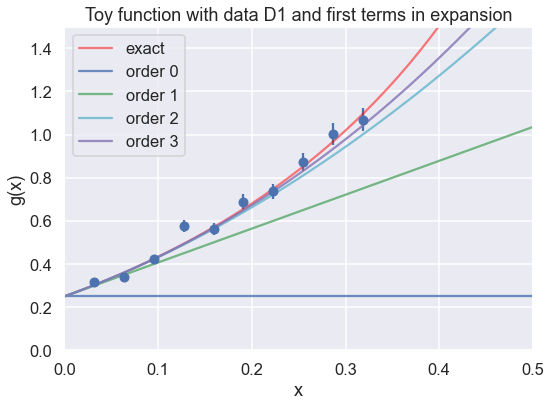

In [5]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x_data_pts, y_data_pts, dy_data, fmt='o')
ax.set_xlabel(r'x')
ax.set_ylabel(r'g(x)')
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 1.5)

x_pts_all = np.arange(0., 1., .01)
ax.plot(x_pts_all, g_func(x_pts_all, percent_error_in_decimal=0 ), color='red', alpha=0.5, label='exact')
ax.set_title('Toy function with data D1 and first terms in expansion')

theta_true = np.array([0.25, 1.5707963, 2.4674011, 1.2919282, 4.0587121, 1.275082, 5.67486677])
colors = ['b', 'g', 'c', 'm', 'k', 'r', 'b']

ndim = 4
for order in range(ndim):
    ax.plot(x_pts_all, y_model(x_pts_all, theta_true[:ndim], order+1), label=f'order {order:d}', color=colors[order], alpha=0.8)
ax.legend()


fig.tight_layout()


In [6]:
def sample(ndim,nwalkers=50,nsteps=1500, prior=log_gaussian_prior, output=True): #following assignment 3
    #ndim = 2  # number of parameters in the model
    #nwalkers = 50  # number of MCMC walkers
    nburn = 1000  # "burn-in" period to let chains stabilize
    #nsteps = 1500  # number of MCMC steps to take

    # we'll start at random locations within the prior volume
    starting_guesses = np.random.rand(nwalkers,ndim)

    #print(f'starting guesses: {starting_guesses}')
    if output==True:
        print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x_data_pts, y_data_pts, dy_data, prior])

    # "burn-in" period; save final positions and then reset
    pos, prob, state = sampler.run_mcmc(starting_guesses, nburn)
    sampler.reset()

    # sampling period
    sampler.run_mcmc(pos, nsteps)
    text = "Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(np.mean(sampler.acceptance_fraction),nwalkers*nsteps)
    if output==True:
        print(text)

    # discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
    samples = sampler.chain.reshape((-1, ndim))
    return samples, starting_guesses, sampler

In [7]:
def corner_plots(samples, ndim, theta_true):
    labelz = []
    for order in range(ndim):
        label = f'a{order}'
        labelz.append(label)
    fig = corner.corner(samples, labels=labelz, 
                        truths=theta_true[:ndim], quantiles=[0.16, 0.5, 0.84],
                        show_titles=True, title_kwargs={"fontsize": 12})

In [8]:
def quantiles(samples, ndim): #following advice given above
    lower = np.zeros(ndim)
    mid = np.zeros(ndim)
    upper = np.zeros(ndim)
    for i in range(ndim):
        mcmc = np.percentile(samples[:, i], [16, 50, 84])
        mid[i] = mcmc[1]
        lower[i], upper[i] = np.diff(mcmc)
    return mid, lower, upper

MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.593 (in total 75000 steps)
(array([0.24678646, 1.65172983, 3.00214442, 0.25887163]), array([0.02354011, 0.4475832 , 2.26903812, 4.30049754]), array([0.02370324, 0.44167621, 2.26965567, 4.34940737]))


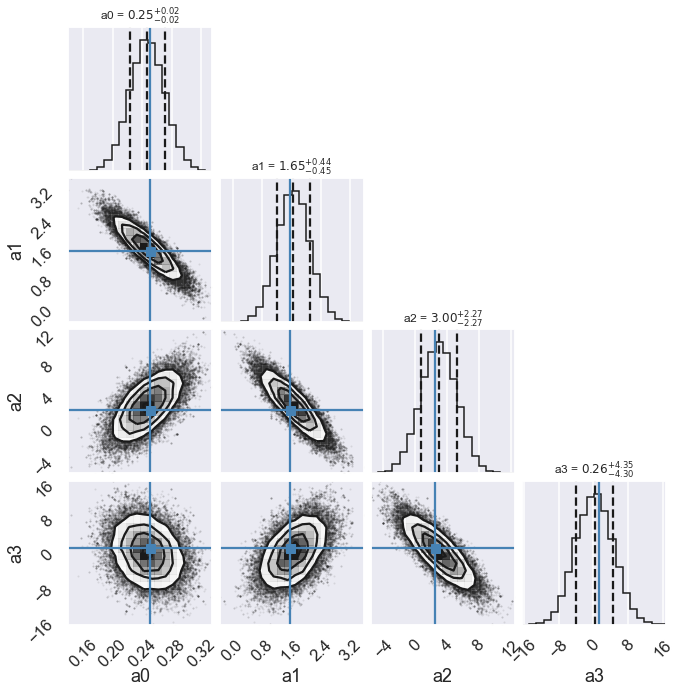

In [9]:
ndim = 4
samples, start_guesses, sampler = sample(ndim) 
corner_plots(samples, ndim, theta_true)
print(quantiles(samples, ndim))
#print(samples)

In [10]:
# from IPython.display import display, Math
print('format: k_max, a0, a1, a2')
print('')
print('Uniform Prior')
print('')
for ndim in np.arange(1,8):
    samples,_,_ = sample(ndim, prior=log_uniform_prior, output=False) 
    mid, lower, upper = quantiles(samples, ndim)
    k_max = ndim - 1
    print(f'{k_max} ', end='')
    for i in np.arange(ndim):
        if i == 3:
            break
        print(f'{mid[i]:.2f}+{upper[i]:.2f}-{lower[i]:.2f} ', end=' ')
    print()

print('')
print('Gaussian Prior')
print('')
for ndim in np.arange(1,8):
    samples,_,_ = sample(ndim, prior=log_gaussian_prior, output=False) 
    mid, lower, higher = quantiles(samples, ndim)
    k_max = ndim - 1
    print(f'{k_max} ', end='')
    for i in np.arange(ndim):
        if i == 3:
            break
        print(f'{mid[i]:.2f}+{upper[i]:.2f}-{lower[i]:.2f} ', end=' ')
    print()

format: k_max, a0, a1, a2

Uniform Prior

0 0.48+0.01-0.01  
1 0.20+0.01-0.01  2.55+0.11-0.10  
2 0.25+0.02-0.02  1.56+0.40-0.40  3.38+1.32-1.31  
3 0.27+0.04-0.04  0.92+1.12-1.07  8.40+7.83-8.11  
4 0.32+0.05-0.06  -1.39+2.38-2.02  39.12+23.44-28.99  
5 0.31+0.06-0.06  -1.00+2.31-2.27  33.29+25.75-28.23  
6 0.32+0.06-0.06  -1.18+2.46-2.25  35.11+26.05-29.03  

Gaussian Prior

0 0.48+0.06-0.01  
1 0.20+0.06-0.01  2.56+2.46-0.11  
2 0.25+0.06-0.02  1.63+2.46-0.38  3.15+26.05-1.26  
3 0.25+0.06-0.02  1.65+2.46-0.45  2.90+26.05-2.27  
4 0.25+0.06-0.02  1.62+2.46-0.44  3.09+26.05-2.40  
5 0.25+0.06-0.02  1.63+2.46-0.45  3.13+26.05-2.37  
6 0.25+0.06-0.02  1.64+2.46-0.45  3.07+26.05-2.38  


### Bonus: additional subtasks 

Do one or more of these to get a plus.

* Reproduce Figures 3 and 4, showing the predictions with error bands for the two priors compared to the true function.  You can use Matplotlib's `fill_between(x, y-error, y+error)` to make bands.  (Use the `alpha` keyword for `fill_between`, e.g., `alpha=0.5`, to make the bands more transparent.)
* Reproduce Figure 5 (alternative prior and "returning the prior"), 
* Reproduce Figure 6 (posterior for $\overline a$), and 7 ("relaxing to least squares").  
* Reproduce Figure 9 (sensitivity to choice of $x_{\rm max}$)
* Repeat analysis with same function but different data precision and/or quantity (number of data points).
* Repeat analysis with a different function from the paper or invent your own function and analyze.


In [11]:
#read in the D1_c_5.dat from the source
source = "https://arxiv.org/src/1511.03618v3/anc/D1_c_5.dat"
columns = ['x_data', 'y_data', 'dy_data']
data = pd.read_csv(source, names=columns, sep='\t+', comment='#', engine='python')
#display(data)
x_data_pts = data['x_data'].to_numpy()
y_data_pts = data['y_data'].to_numpy()
dy_data = data['dy_data'].to_numpy()

In [12]:
#Lets change the a_max of the uniform prior from 500 to 5
def log_uniform_prior(theta , a_max=5): #following notebook 2.5
    if np.all(np.abs(theta) <= a_max):
        return 0 # log(1)
    else:
        return -np.inf  # log(0)

MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.539 (in total 75000 steps)
(array([0.24593833, 1.66466108, 2.96774597, 0.64729496]), array([0.02186556, 0.31775351, 1.77756758, 3.2204891 ]), array([0.01975898, 0.3959171 , 1.34549819, 2.8549856 ]))


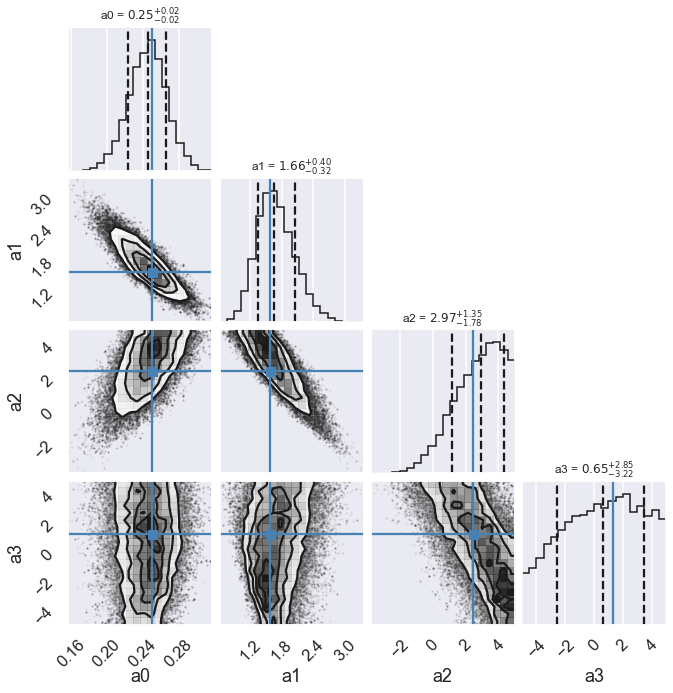

In [13]:

ndim = 4
samples, start_guesses, sampler = sample(ndim, prior = log_uniform_prior) 
corner_plots(samples, ndim, theta_true)
print(quantiles(samples, ndim))
#print(samples)

In [14]:
# from IPython.display import display, Math
print('format: k_max, a0, a1, a2')
print('')
print('Uniform Prior')
print('')
for ndim in np.arange(1,8):
    samples,_,_ = sample(ndim, prior=log_uniform_prior, output=False) 
    mid, lower, upper = quantiles(samples, ndim)
    k_max = ndim - 1
    print(f'{k_max} ', end='')
    for i in np.arange(ndim):
        if i == 3:
            break
        print(f'{mid[i]:.2f}+{upper[i]:.2f}-{lower[i]:.2f} ', end=' ')
    print()

print('')
print('Gaussian Prior')
print('')
for ndim in np.arange(1,8):
    samples,_,_ = sample(ndim,prior=log_gaussian_prior, output=False) 
    mid, lower, higher = quantiles(samples, ndim)
    k_max = ndim - 1
    print(f'{k_max} ', end='')
    for i in np.arange(ndim):
        if i == 3:
            break
        print(f'{mid[i]:.2f}+{upper[i]:.2f}-{lower[i]:.2f} ', end=' ')
    print()

format: k_max, a0, a1, a2

Uniform Prior

0 0.48+0.01-0.01  
1 0.20+0.01-0.01  2.55+0.11-0.11  
2 0.25+0.02-0.02  1.63+0.38-0.33  3.15+1.09-1.24  
3 0.24+0.02-0.02  1.68+0.39-0.31  2.92+1.33-1.66  
4 0.25+0.02-0.02  1.66+0.39-0.31  2.97+1.31-1.68  
5 0.24+0.02-0.02  1.71+0.39-0.35  2.80+1.40-1.73  
6 0.24+0.02-0.02  1.67+0.37-0.30  2.97+1.36-1.66  

Gaussian Prior

0 0.48+0.02-0.01  
1 0.20+0.02-0.01  2.56+0.37-0.10  
2 0.25+0.02-0.02  1.61+0.37-0.40  3.19+1.36-1.28  
3 0.25+0.02-0.02  1.66+0.37-0.45  2.95+1.36-2.29  
4 0.25+0.02-0.02  1.65+0.37-0.46  2.97+1.36-2.34  
5 0.25+0.02-0.02  1.68+0.37-0.47  2.87+1.36-2.39  
6 0.25+0.02-0.02  1.67+0.37-0.47  2.85+1.36-2.41  


The uniform prior now seems like the gaussian prior

In [15]:
#Lets change the a_max of the uniform prior from 500 to 2
def log_uniform_prior(theta , a_max=2): #following notebook 2.5
    if np.all(np.abs(theta) <= a_max):
        return 0 # log(1)
    else:
        return -np.inf  # log(0)

In [16]:
# from IPython.display import display, Math
print('format: k_max, a0, a1, a2')
print('')
print('Uniform Prior')
print('')
for ndim in np.arange(1,8):
    samples,_,_ = sample(ndim, prior=log_uniform_prior, output=False) 
    mid, lower, upper = quantiles(samples, ndim)
    k_max = ndim - 1
    print(f'{k_max} ', end='')
    for i in np.arange(ndim):
        if i == 3:
            break
        print(f'{mid[i]:.2f}+{upper[i]:.2f}-{lower[i]:.2f} ', end=' ')
    print()

print('')
print('Gaussian Prior')
print('')
for ndim in np.arange(1,8):
    samples,_,_ = sample(ndim,prior=log_gaussian_prior, output=False) 
    mid, lower, higher = quantiles(samples, ndim)
    k_max = ndim - 1
    print(f'{k_max} ', end='')
    for i in np.arange(ndim):
        if i == 3:
            break
        print(f'{mid[i]:.2f}+{upper[i]:.2f}-{lower[i]:.2f} ', end=' ')
    print()

format: k_max, a0, a1, a2

Uniform Prior

0 0.48+0.01-0.01  
1 0.26+0.01-0.01  1.99+0.01-0.02  
2 0.24+0.01-0.01  1.93+0.05-0.08  1.82+0.13-0.22  
3 0.24+0.01-0.01  1.92+0.05-0.10  1.75+0.18-0.29  
4 0.24+0.01-0.01  1.91+0.06-0.10  1.76+0.17-0.31  
5 0.24+0.01-0.01  1.90+0.07-0.10  1.77+0.17-0.32  
6 0.24+0.01-0.01  1.91+0.06-0.10  1.73+0.20-0.31  

Gaussian Prior

0 0.48+0.01-0.01  
1 0.20+0.01-0.01  2.55+0.06-0.10  
2 0.25+0.01-0.02  1.62+0.06-0.39  3.17+0.20-1.27  
3 0.25+0.01-0.02  1.64+0.06-0.46  2.91+0.20-2.30  
4 0.25+0.01-0.02  1.63+0.06-0.46  3.01+0.20-2.43  
5 0.25+0.01-0.02  1.64+0.06-0.46  2.97+0.20-2.31  
6 0.25+0.01-0.02  1.66+0.06-0.45  2.93+0.20-2.35  
